First things first:

In [2]:
import sys
import numpy as np
import pyvista as pv
import matplotlib.pyplot as plt
from tqdm import tqdm

sys.path.append('../wakis/')

from wakis import SolverFIT3D
from wakis import GridFIT3D 
from wakis import WakeSolver

In [3]:
# For static images
pv.set_jupyter_backend('html')

Read and plot the geometry files:

In [ ]:
# ---------- Domain setup ---------
# Number of mesh cells
Nx = 100
Ny = 100
Nz = 161
#dt = 2.187760221e-12 # CST

# Embedded boundaries
stl_cavity = 'stl/cavity_vacuum.stl' 
stl_shell = 'stl/cavity_shell.stl'
stl_letters = 'stl/CEI_heart_courier_new.stl'

stl_solids = {'cavity': stl_cavity, 
              'shell': stl_shell,
              'letters' : stl_letters}

stl_materials = {'cavity': 'vacuum', 
                 'shell': [30, 1.0, 30],
                 'letters' : 'pec'}

stl_rotate = {'cavity': [0., 0., 0.],
                'shell': [0., 0., 0.],
                'letters' : [180, -90, 0]}

stl_translate = {'cavity': [0., 0., 0.],
                 'shell': [0., 0., 0.],
                 'letters' : [-10, 0, 35]}


stl_scale = {'cavity': [1., 1., 1.],
                 'shell': [1., 1., 1.],
                 'letters' : [0.7e-2, 0.4e-2, 0.4e-2]}

# Domain bounds
letters = pv.read(stl_letters) \
        .rotate_x(stl_rotate['letters'][0]) \
        .rotate_y(stl_rotate['letters'][1]) \
        .rotate_z(stl_rotate['letters'][2]) \
        .translate(stl_translate['letters']) \
        .scale(stl_scale['letters'])

surf = pv.read(stl_shell)+letters

EmbeddableWidget(value='<iframe srcdoc="<!DOCTYPE html>\n<html>\n  <head>\n    <meta http-equiv=&quot;Content-…

Generate the simulation grid and inspect it:

In [6]:
xmin, xmax, ymin, ymax, zmin, zmax = surf.bounds
# set grid and geometry
grid = GridFIT3D(xmin, xmax, ymin, ymax, zmin, zmax, Nx, Ny, Nz, 
                stl_solids=stl_solids, 
                stl_materials=stl_materials,
                stl_scale=stl_scale,
                stl_rotate=stl_rotate,
                stl_translate=stl_translate)

Generating grid...
Importing stl solids...


In [7]:
grid.inspect()

EmbeddableWidget(value='<iframe srcdoc="<!DOCTYPE html>\n<html>\n  <head>\n    <meta http-equiv=&quot;Content-…

Define the wake and beam parameters:

In [ ]:
# ------------ Beam source ----------------
# Beam parameters
sigmaz = 10e-2      #[m] -> 2 GHz
q = 1e-9            #[C]
beta = 1.0          # beam beta 
xs = 0.             # x source position [m]
ys = 0.             # y source position [m]
xt = 0.             # x test position [m]
yt = 0.             # y test position [m]
# [DEFAULT] tinj = 8.53*sigmaz/c_light  # injection time offset [s] 

# Simualtion
wakelength = 10. #[m]
add_space = 10   # no. cells

wake = WakeSolver(q=q, sigmaz=sigmaz, beta=beta,
            xsource=xs, ysource=ys, xtest=xt, ytest=yt,
            add_space=add_space, save=False,
            logfile=False)

Assembling operator matrices...
Applying boundary conditions...
Adding material tensors...
Calculating maximal stable timestep...
Pre-computing...
Total initialization time: 4.75523829460144 s


Define the solver's boundary conditions, background

In [ ]:
# ----------- Solver & Simulation ----------
# boundary conditions``
bc_low=['pec', 'pec', 'pec']
bc_high=['pec', 'pec', 'pec']

solver = SolverFIT3D(grid, wake, #dt=dt,
                     bc_low=bc_low, bc_high=bc_high, 
                     use_stl=True, bg='pec')

Inspect the resulting material tensors, for example the permittivity $\varepsilon ^{-1}$

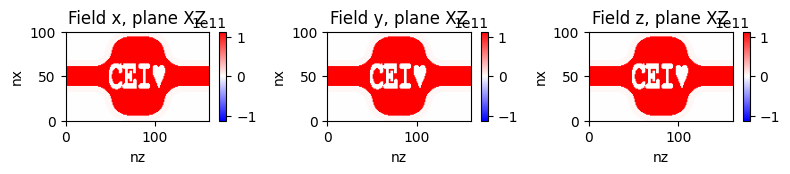

In [9]:
solver.ieps.inspect(plane='XZ')

Prepare 2D plot settings for on-the-fly plots

In [ ]:
# Plot settings
n=0
from matplotlib.colors import LinearSegmentedColormap
cmap = LinearSegmentedColormap.from_list('name', plt.cm.jet(np.linspace(0.05, 0.9))) # CST's colormap

plotkw2D = {'title':'img/E_z', 
            'add_patch':['cavity'], 'patch_alpha':0.9,
            'patch_reverse' : True, 
            'vmin':0, 'vmax':700,
            'interpolation' : 'gaussian',
            'cmap' : cmap,
            'plane': [slice(0, Nx), int(Ny/2), slice(0, Nz)]}

#solver.plot2D('E', component='Abs', **plotkw2D, off_screen=True, n=n)

Run the wakefield simulation with dedicated routine `wakesolve`